<a href="https://colab.research.google.com/github/nazaninbondarian/MachineLearning2024/blob/main/Chapter%204/Q1score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt
#random.seed(76)  # Initialize the random number generator with a seed value of 42

# Define the grid size and initial positions
grid_size = 4
pits = [(1, 2), (2, 0), (3, 3)]  # Adjusted to 0-based indexing
wumpus = (2, 1)  # Adjusted to 0-based indexing
gold = (3, 2)  # Adjusted to 0-based indexing
start = (0, 0)  # Adjusted to 0-based indexing
other_points = [(0, 1), (1, 1), (1, 3), (2, 2), (2, 3), (3, 0)]  # Any other points

# Create an empty grid
grid = [["." for _ in range(grid_size)] for _ in range(grid_size)]

# Mark specific positions in the grid
grid[start[0]][start[1]] = "S"
for pit in pits:
    grid[pit[0]][pit[1]] = "P"
grid[wumpus[0]][wumpus[1]] = "W"
grid[gold[0]][gold[1]] = "G"

# Print the grid
for row in grid:
    print(" ".join(row))

# Rewards dictionary
rewards = {}
for x in range(grid_size):
    for y in range(grid_size):
        rewards[(x, y)] = -1
rewards[gold] = 100
for pit in pits:
    rewards[pit] = -1000
rewards[wumpus] = -1000

# Define actions
actions = ['up', 'down', 'left', 'right']

# Define the Q-table
Q = np.zeros((grid_size, grid_size, len(actions)))

S . . .
. . P .
P W . .
. . G P


In [14]:
# Helper function to get the next state
def get_next_state(state, action):
    x, y = state
    if action == 'up':
        return (max(x - 1, 0), y)
    elif action == 'down':
        return (min(x + 1, grid_size - 1), y)
    elif action == 'left':
        return (x, max(y - 1, 0))
    elif action == 'right':
        return (x, min(y + 1, grid_size - 1))

# Function to shoot an arrow
def shoot_arrow(state, direction):
    x, y = state
    wx, wy = wumpus
    if direction == 'up':
      if wx == x and wy < y:
        return 50 # Reward for killing the Wumpus

    elif direction == 'down':
      if wx == x and wy > y:
        return 50 # Reward for killing the Wumpus

    elif direction == 'left':
      if wy == y and wx < x:
        return 50 # Reward for killing the Wumpus

    elif direction == 'right':
      if wy == y and wx > x:
        return 50 # Reward for killing the Wumpus

    return 0  # No reward if the Wumpus is not hit

In [15]:
# Q-Learning
def q_learning(episodes, consistency_threshold=10):
    Q = np.zeros((grid_size, grid_size, len(actions)))
    learning_rate = 0.1
    discount_factor = 0.9
    exploration_rate = 1.0
    exploration_decay = 0.995
    min_exploration_rate = 0.01
    cumulative_rewards = []
    consecutive_successes = 0
    episodes_to_consistency = None

    for episode in range(episodes):
        state = start
        total_reward = 0
        done = False
        success = False

        while not done:
            if random.uniform(0, 1) < exploration_rate:
                action = random.choice(actions)
            else:
                action = actions[np.argmax(Q[state[0], state[1]])]

            next_state = get_next_state(state, action)
            reward = rewards[next_state]
            total_reward += reward

            # Check if shooting the arrow is required and calculate additional reward
            shoot_reward = shoot_arrow(state, action)
            total_reward += shoot_reward

            # Update Q-value
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], actions.index(action)] += learning_rate * (
                reward + discount_factor * Q[next_state[0], next_state[1], best_next_action] -
                Q[state[0], state[1], actions.index(action)]
            )

            state = next_state

            if state == gold:
                done = True
                success = True
            elif reward == -1000:  # Pit or Wumpus
                done = True
                success = False

        if success:
            consecutive_successes += 1
            if consecutive_successes == consistency_threshold and episodes_to_consistency is None:
                episodes_to_consistency = episode + 1
        else:
            consecutive_successes = 0

        exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)
        cumulative_rewards.append(total_reward)

    return cumulative_rewards, episodes_to_consistency


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_state_vector(state):
    state_vector = np.zeros(grid_size * grid_size)
    state_vector[state[0] * grid_size + state[1]] = 1
    return state_vector

def dqn_learning(episodes, actions, consistency_threshold=10):
    input_dim = grid_size * grid_size
    output_dim = len(actions)
    dqn = DQN(input_dim, output_dim)
    optimizer = optim.Adam(dqn.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    exploration_rate = 1.0
    exploration_decay = 0.995
    min_exploration_rate = 0.01
    discount_factor = 0.9
    batch_size = 32
    memory = []
    cumulative_rewards = []
    consecutive_successes = 0
    episodes_to_consistency = None

    for episode in range(episodes):
        state = start
        total_reward = 0
        done = False
        success = False

        while not done:
            if random.uniform(0, 1) < exploration_rate:
                action = random.choice(actions)
            else:
                state_vector = torch.FloatTensor(get_state_vector(state)).unsqueeze(0)
                q_values = dqn(state_vector)
                action = actions[torch.argmax(q_values).item()]

            next_state = get_next_state(state, action)
            reward = rewards[next_state]
            total_reward += reward

            # Check if shooting the arrow is required and calculate additional reward
            shoot_reward = shoot_arrow(state, action)
            total_reward += shoot_reward

            memory.append((state, action, reward, next_state))

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions_batch, rewards_batch, next_states = zip(*batch)

                state_vectors = torch.FloatTensor([get_state_vector(s) for s in states])
                next_state_vectors = torch.FloatTensor([get_state_vector(s) for s in next_states])

                q_values = dqn(state_vectors)
                next_q_values = dqn(next_state_vectors)

                targets = q_values.clone()
                for i in range(batch_size):
                    targets[i][actions.index(actions_batch[i])] = rewards_batch[i] + discount_factor * torch.max(next_q_values[i]).item()

                optimizer.zero_grad()
                loss = criterion(q_values, targets)
                loss.backward()
                optimizer.step()

            state = next_state

            if state == gold:
                done = True
                success = True
            elif reward == -1000:  # Pit or Wumpus
                done = True
                success = False

        if success:
            consecutive_successes += 1
            if consecutive_successes == consistency_threshold and episodes_to_consistency is None:
                episodes_to_consistency = episode + 1
        else:
            consecutive_successes = 0

        exploration_rate = max(min_exploration_rate, exploration_rate * exploration_decay)
        cumulative_rewards.append(total_reward)

    return cumulative_rewards, episodes_to_consistency


In [17]:
# Run Q-learning
episodes = 1000
q_rewards, q_consistency_achieved = q_learning(episodes)
print("Training completed with Q-learning.")

Training completed with Q-learning.


In [18]:
# Run DQN
dqn_rewards, dqn_consistency_achieved = dqn_learning(episodes, actions)
print("Training completed with Deep Q-learning.")

Training completed with Deep Q-learning.


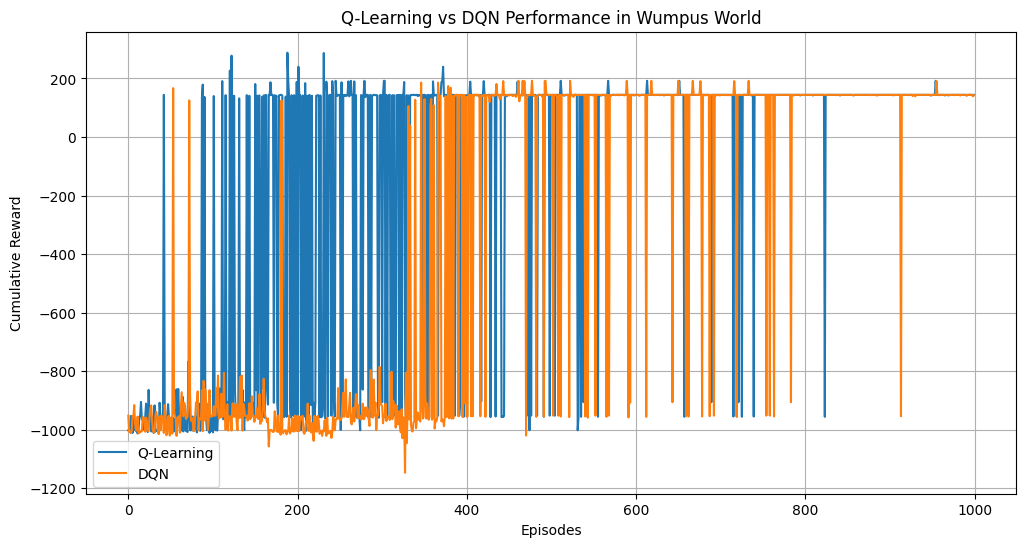

In [19]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(q_rewards, label='Q-Learning')
plt.plot(dqn_rewards, label='DQN')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Q-Learning vs DQN Performance in Wumpus World')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Calculate average reward per episode
avg_q_reward = np.mean(q_rewards)
avg_dqn_reward = np.mean(dqn_rewards)

print(f"Average reward per episode for Q-Learning: {avg_q_reward}")
print(f"Average reward per episode for DQN: {avg_dqn_reward}")

# Determine which algorithm performed better
if avg_q_reward > avg_dqn_reward:
    print("Q-Learning performed better.")
else:
    print("DQN performed better.")

Average reward per episode for Q-Learning: -124.02
Average reward per episode for DQN: -298.564
Q-Learning performed better.


In [21]:
# Consistency results
if q_consistency_achieved:
    print(f"Q-learning agent achieved consistent performance after {q_consistency_achieved} episodes")
else:
    print("Q-learning agent did not achieve consistent performance within the given number of episodes")

if dqn_consistency_achieved:
    print(f"DQN agent achieved consistent performance after {dqn_consistency_achieved} episodes")
else:
    print("DQN agent did not achieve consistent performance within the given number of episodes")

Q-learning agent achieved consistent performance after 264 episodes
DQN agent achieved consistent performance after 433 episodes
